## 7-2. 사이킷런을 이용한 토픽 모델링

### 데이터 준비
20 뉴스그룹 데이터를 사용해 토픽 모델링을 실습하고자 한다. 익숙한 데이터이므로 결과를 해석하기에도 용이하다. 문서분류와는 달리 예측을 할 필요가 없으므로 학습 데이터만 사용한다. 문서 분류에서는 네 개의 카테고리만 선택했으나, 여기서는 좀 더 다양한 토픽들을 살펴보기 위해 여섯 개로 카테고리를 늘린다.

In [1]:
from sklearn.datasets import fetch_20newsgroups

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 'comp.sys.ibm.pc.hardware', 'sci.crypt']

# 학습 데이터셋을 가져옴
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories)

print('# Train set size:', len(newsgroups_train.data))
print('# Selected categories:', newsgroups_train.target_names)

# Train set size: 3219
# Selected categories: ['alt.atheism', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.crypt', 'sci.space', 'talk.religion.misc']


데이터가 준비되면 카운트 벡터를 생성한다. 사이킷런의 LDA 라이브러리는 카운트 벡터를 입력으로 사용한다. 문서분류에서는 단어 수를 제한하지 않는 편이 가장 좋은 성능을 보였으나, 수행 시간을 고려해 초기에 사용했던 인수들을 그대로 사용한다. 즉 특성 수를 2,000개로 제한하고 min_df와 max_df를 각각 5와 0.5로 해서 변환한다.

In [2]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(token_pattern="[\w']{3,}", stop_words='english', max_features=2000, min_df=5, max_df=0.5)
review_cv = cv.fit_transform(newsgroups_train.data) 

### LDA 토픽 모델링 실행
사이킷런에서 LDA를 지원하는 클래스는 [LatentDirichletAllocation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html)이다. 앞선 설명에서 하이퍼 파라미터로 말했던 토픽의 수, α, β 외에 max_iter, learning_method, n_jobs, random_stete 매개변수가 있다. 먼저 n_components는 토픽의 수를 지정한다. 우선은 10으로 시작하지만 가장 중요한 하이퍼 파라미터이므로 최적값을 찾는 방법을 이후에 알아본다.

매개변수 max_iter는 알고리즘의 최대 반복 횟수다. 보통 최종 모형에서는 충분히 큰 값을 준다고 하지만, 그 이전에 수렴하는 경우도 많으므로 적절하게 선택하면 된다. 기본값은 10이다. 실습이므로 시간이 많이 걸린다면 더 줄여도 되지만 5 이하가 되면 제대로 결과가 안 나올 수 있다.

topic_word_prior는 β를 말하며, 앞선 설명과 같이 토픽의 사전 단어분포를 결정하는 매개변수다. 기본값은 1/n_components다. doc_topic_prior는 α를 의미하며 문서의 사전 토픽분포를 결정한다. 기본값은 마찬가지로 일반적으로 n_components다. 이 두 값을 얼마로 설정하는 것이 좋은지에 대해 정해진 답은 없다. 다만 토픽 모델링으로 유명한 논문에서 β는 0.1, α는 50/n_components 값을 사용했으므로 이 근처에서 직접 적절한 값을 찾아보는 것을 추첞나다. 다만 논문에서는 토픽의 수를 10에서 1,000개까지 테스트하는 동안 값을 변경햇으므로 실습에서는 1.0 정도로 해본다.

learning_method는 batch와 online의 두 값이 있으며, batch가 online에 비해 더 성능이 좋은 대신 느리다. n_jobs는 실행 시 사용하는 프로세서의 수로 값을 주지 않으면 한 개, -1이면 가능한 모든 프로세서를 사용한다. random_state는 지금까지와 마찬가지로 랜덤 시드를 지정해 재실행 및 확인이 가능하도록 해준다.

아래와 같이 기본적인 인수를 주고 실행해보자.

In [3]:
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
np.set_printoptions(precision=3)

lda = LatentDirichletAllocation(n_components=10, # 추출할 topic의 수
                                max_iter=5, 
                                topic_word_prior=0.1, doc_topic_prior=1.0,
                                learning_method='online', 
                                n_jobs=-1, # 사용 processor 수
                                random_state=0)

review_topics = lda.fit_transform(review_cv)
print('# shape of review_topics:', review_topics.shape)
print('# Sample of review_topics:', review_topics[0])

gross_topic_weights = np.mean(review_topics, axis=0)
print('# Sum of topic weights of documents:', gross_topic_weights)

print('# shape of topic word distribution:', lda.components_.shape)

# shape of review_topics: (3219, 10)
# Sample of review_topics: [0.015 0.007 0.008 0.829 0.008 0.008 0.02  0.007 0.007 0.091]
# Sum of topic weights of documents: [0.082 0.082 0.094 0.109 0.114 0.138 0.086 0.071 0.072 0.152]
# shape of topic word distribution: (10, 2000)


위 결과를 보면 LDA를 이용해 학습하고 변환한 결과가 저장된 review_topics의 shape이 (3219, 10)인 것을 볼 수 있는데, 여기서 행은 각 문서 그대로이고 열의 값들은 LDA가 추출한 토픽의 비중을 나타낸다. 즉 LDA 변환결과는 각 문서별로 토픽분포를 보여주며, 이는 위 LDA의 원리 설명에서 θ에 해당한다.

위 결과와 같이 review_topics의 첫째 행을 출력하면 첫 문서의 각 토픽에 대한 분포를 볼 수 있으며, 넷째 토픽의 비중이 압도적으로 크고 나머지는 비슷한 것을 알 수 있다. numpy로 열에 대해 총합을 구하면 문서 전체에 나타난 토픽의 평균 분포를 알 수 있다. 즉 말뭉치 전체에서는 10번째 토픽이 15.2%로 가장 많이 나타났으며, 다음이 13.8%인 6번째 토픽이다.

그러나 위 결과만 가지고는 각 토픽의 내용을 알 수 없다. 토픽의 단어 분포를 보면 토픽의 내용을 짐작할 수 있는데, 이는 LDA 모형에서 φ에 해당하고, 사이킷런의 LDA 클래스에서는 components_ 속성이 이 값을 가지고 있다. 위 예와 같이 lda_components_의 shape을 출력해보면 (10, 2000)이 나오는데, 이는 각 토픽에 대해 카운트 벡터에서 사용한 단어 2,000개의 비중을 표현하기 때문이다.

토픽의 내용을 파악하려고 모든 단어의 비중을 들여다보는 것은 사실상 불가능하므로, 보통은 가장 비중이 높은 단어 10~20개 정도를 본다. 토픽별로 비중이 높은 상위 단어들을 찾아 순서대로 출력하기 위해 아래와 같이 print_top_words 함수를 정의하고, 위 결과에 적용해본다.

In [4]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d: " % topic_idx, end='')
        print(", ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # print(", ".join([feature_names[i]+'('+str(topic[i])+')' for i in topic.argsort()[:-n_top_words - 1:-1]]))
        # 위 slicing에서 맨 뒤 -1은 역순을 의미, 역순으로 했을 때 처음부터 n_top_words까지
    print()

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: com, article, sandvik, apple, university, kent, science, wrote, islam, frank
Topic #1: image, graphics, file, files, ftp, software, available, program, data, use
Topic #2: com, access, posting, net, digex, article, ibm, internet, like, pat
Topic #3: article, com, don't, keith, nntp, think, host, just, posting, sgi
Topic #4: key, clipper, chip, encryption, government, com, keys, law, escrow, use
Topic #5: scsi, university, nntp, host, thanks, posting, com, know, bit, bus
Topic #6: space, nasa, gov, launch, orbit, center, earth, shuttle, satellite, research
Topic #7: drive, disk, hard, com, controller, drives, dos, problem, tape, floppy
Topic #8: key, public, mail, faq, message, pgp, information, university, group, des
Topic #9: god, people, don't, jesus, just, think, say, believe, does, know



위 결과를 보고 토픽이 제대로 분류됐는지 확인하는 것은 분석가의 몫이다. 1번 토픽의 경우 image, graphics, file, software 등의 단어를 통해 말뭉치를 이루는 카테고리들 중 graphics에 해당하는 토픽임을 짐작할 수 있다. 마찬가지로 2번 토픽은 space, nasam access, launch, earth 등을 통해 space에 대한 토픽임을 알 수 있다.

토픽 모델링을 수행한 결과에 대한 논문이나 신문기사를 보면 토픽에 제목이 있다. 이 제목은 통상적으로 분석가가 판단해서 만든다. 상위 비중을 차지하는 단어들을 보고 짐작해 이름을 짓는데, 이 과정에서 분석가의 해석이 많이 반영된다. 빈도가 높은 단어들로부터 토픽의 이름을 자동으로 생성하는 시도가 있으나, 아직 높은 정확성을 기대하기는 어렵다.

위에서 적절한 토픽의 수를 결정하기 위해 모형의 성능을 측정하는 것에 대해 언급했는데, 혼란도나 토픽 응집도와 같은 수치에 전적으로 의존하기보다 사람의 판단이 중요하다고 이야기한 것이 바로 이와 같은 맥락이다. 성능상으로 좋은 수치를 보인다 해도 토픽을 해석하기가 어렵다면 좋은 결과라고 하기 어렵다.

### 최적의 토픽 수 선택하기
토픽 모델링에서 가장 중요한 하이퍼 파라미터는 바로 토픽의 수다. 토픽 수를 결정하기 위해 다양한 토픽 수를 적용한 모형들에 대해 혼란도와 토픽 응집도를 계산하는데, 사이킷런은 혼란도만 공식적으로 제공한다. 토픽 응집도를 알고 싶다면 아직까지는 직접 계산해야 한다. 여기서는 perplexity를 계산하고 그래프를 통해 적절한 값을 선택하는 과정을 실습해보고자 한다. 

토픽의 수를 변화시키면서 LDA를 수행하고 preplexity를 계산한 후 그래프로 그려주는 show_perplexity 함수를 아래와 같이 구현했다. 이때 주의할 점은, 시간을 줄이기 위해 max_iter를 너무 낮추면 제대로 수렴이 되지 않아 perplexity값이 높게 나오고 토픽 수에 비례하는 경향이 있다. 따라서 최소 5 이상의 값을 주는 것이 좋다.

n_components: 6, perplexity: 1052.061
n_components: 7, perplexity: 1055.910
n_components: 8, perplexity: 1027.856
n_components: 9, perplexity: 1018.301
n_components: 10, perplexity: 1024.421
n_components: 11, perplexity: 1035.376
n_components: 12, perplexity: 1031.050
n_components: 13, perplexity: 1039.640
n_components: 14, perplexity: 1038.313
n_components: 15, perplexity: 1043.554


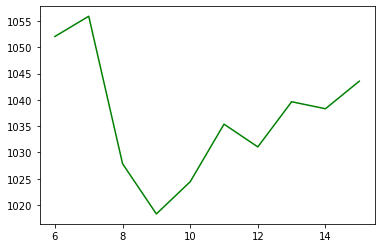

n_components with minimum perplexity: 9


In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_perplexity(cv, start=10, end=30, max_iter=5, topic_word_prior=0.1, doc_topic_prior=1.0):
    iter_num = []
    per_value = []

    for i in range(start, end + 1):
        lda = LatentDirichletAllocation(n_components=i, max_iter=max_iter, topic_word_prior=topic_word_prior, 
                                        doc_topic_prior=doc_topic_prior, learning_method='batch', n_jobs=-1,
                                        random_state=7)    
        lda.fit(cv)
        iter_num.append(i)
        pv = lda.perplexity(cv)
        per_value.append(pv)
        print(f'n_components: {i}, perplexity: {pv:0.3f}')

    plt.plot(iter_num, per_value, 'g-')
    plt.show()
    return start + per_value.index(min(per_value))

print("n_components with minimum perplexity:", show_perplexity(review_cv, start=6, end=15))

위 결과를 보면 토픽의 수가 8일 때 주변의 다른 값에 비해 perplexity가 낮은 것을 볼 수 있다. 물론 몇 개의 대안을 놓고 각각 실행해서 해석이 더 잘되는 모형을 선택하는 것이 바람직하지만, 여기서는 토픽의 수를 8로 놓고 본격적인 LDA를 실행해서 결과를 살펴보기로 한다. max_iter는 5에서 20으로 늘렸다.

In [6]:
lda = LatentDirichletAllocation(n_components=8, # 추출할 topic의 수를 지정
                                max_iter=20, 
                                topic_word_prior=0.1, 
                                doc_topic_prior=1.0,
                                learning_method='batch',
                                n_jobs=-1, 
                                random_state=7)

review_topics = lda.fit_transform(review_cv)

print_top_words(lda, cv.get_feature_names_out(), 10)

Topic #0: graphics, image, mail, available, file, ftp, information, files, data, software
Topic #1: space, nasa, gov, orbit, earth, ___, center, launch, research, washington
Topic #2: com, keith, nntp, host, posting, morality, article, caltech, sgi, objective
Topic #3: com, article, jesus, know, god, just, posting, john, host, nntp
Topic #4: people, god, don't, does, think, say, believe, just, like, way
Topic #5: drive, scsi, com, card, disk, thanks, ide, controller, bus, hard
Topic #6: article, com, just, access, like, posting, nntp, host, space, net
Topic #7: key, encryption, clipper, chip, com, government, keys, use, security, public



처음 선택했던 카테고리가 ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space', 'comp.sys.ibm.pc.hardware', 'sci.crypt'] 였음을 기억해보면, Topic 0: 'comp.graphics', Topic 3: 'talk.religion.misc', Topic 5: 'comp.sys.ibm.pc.hardware', Topic 6: 'sci.space', Topic 7: 'sci.crypt'는 비교적 명확해 보인다. Topic 1과 Topic 2는 살짝 모호해 보이며 (물론 지식이 많다면 해석을 더 잘할 수도 있다), Topic 4는 'alt.atheism'과 'talk.religion.misc'이 섞여 있는 것처럼 보인다.

만일 카테고리에 대한 사전정보가 전혀 없었다면 위 결과가 나름 말뭉치에 내재된 주제들을 잘 분류했다고 볼 수 있을 것이다.